
### 3. Option Market Layer

In this notebook you put a **simple European option layer** on top of your BTC price simulator.

You will:

- Define a **implied volatility (IV) surface** that reacts to maturity, moneyness, and local realised volatility.
- Use **Black–Scholes** with your IV surface to price calls/puts along simulated BTC paths.
- Inspect how IV and option prices behave in **calm vs. volatile** regimes.

(中文提示：这一层只是给后面 hedging 提供一个合理的 option 价格环境，不需要做很复杂的真实市场校准。)

---

#### 3.1 IV Setup and Local Volatility

We work with a European IV surface

$$
\sigma_{\text{IV}}(t, S_t, K, T)
= f\big(\tau,\ K/S_t,\ \hat{\sigma}_{\text{loc}}(t)\big),
\quad
\tau = T - t.
$$

Here:

- $\tau$: time to maturity.
- $K/S_t$: moneyness.
- $\hat{\sigma}_{\text{loc}}(t)$: **local realised volatility**, computed from your simulated BTC log-returns via a rolling window (e.g. last 1–4 hours of 5-minute returns, annualised).


**Minimal requirements**

- $\sigma_{\text{IV}}$ should depend on **maturity**:
  - Short-dated vs. longer-dated options can have different base vol levels.
- $\sigma_{\text{IV}}$ should depend on **moneyness**:
  - At least distinguish ATM vs. OTM (e.g. a tiny smile/skew).
- $\sigma_{\text{IV}}$ should react to **local realised volatility**:
  - Higher when $\hat{\sigma}_{\text{loc}}(t)$ is high (volatile regime),
  - Lower when $\hat{\sigma}_{\text{loc}}(t)$ is low (calm regime).


**Implementation tasks**

- Implement a rolling estimator for $\hat{\sigma}_{\text{loc}}(t)$ from your simulator paths.
- Choose a small number of parameters for $f(\cdot)$, and write down your formula clearly in the notebook.
- Implement the function  
 




IV曲面参数:
基础波动率: 60.0%
波动率敏感度: 80.0%
期限结构斜率: 15.0%
微笑曲线强度: 30.0%


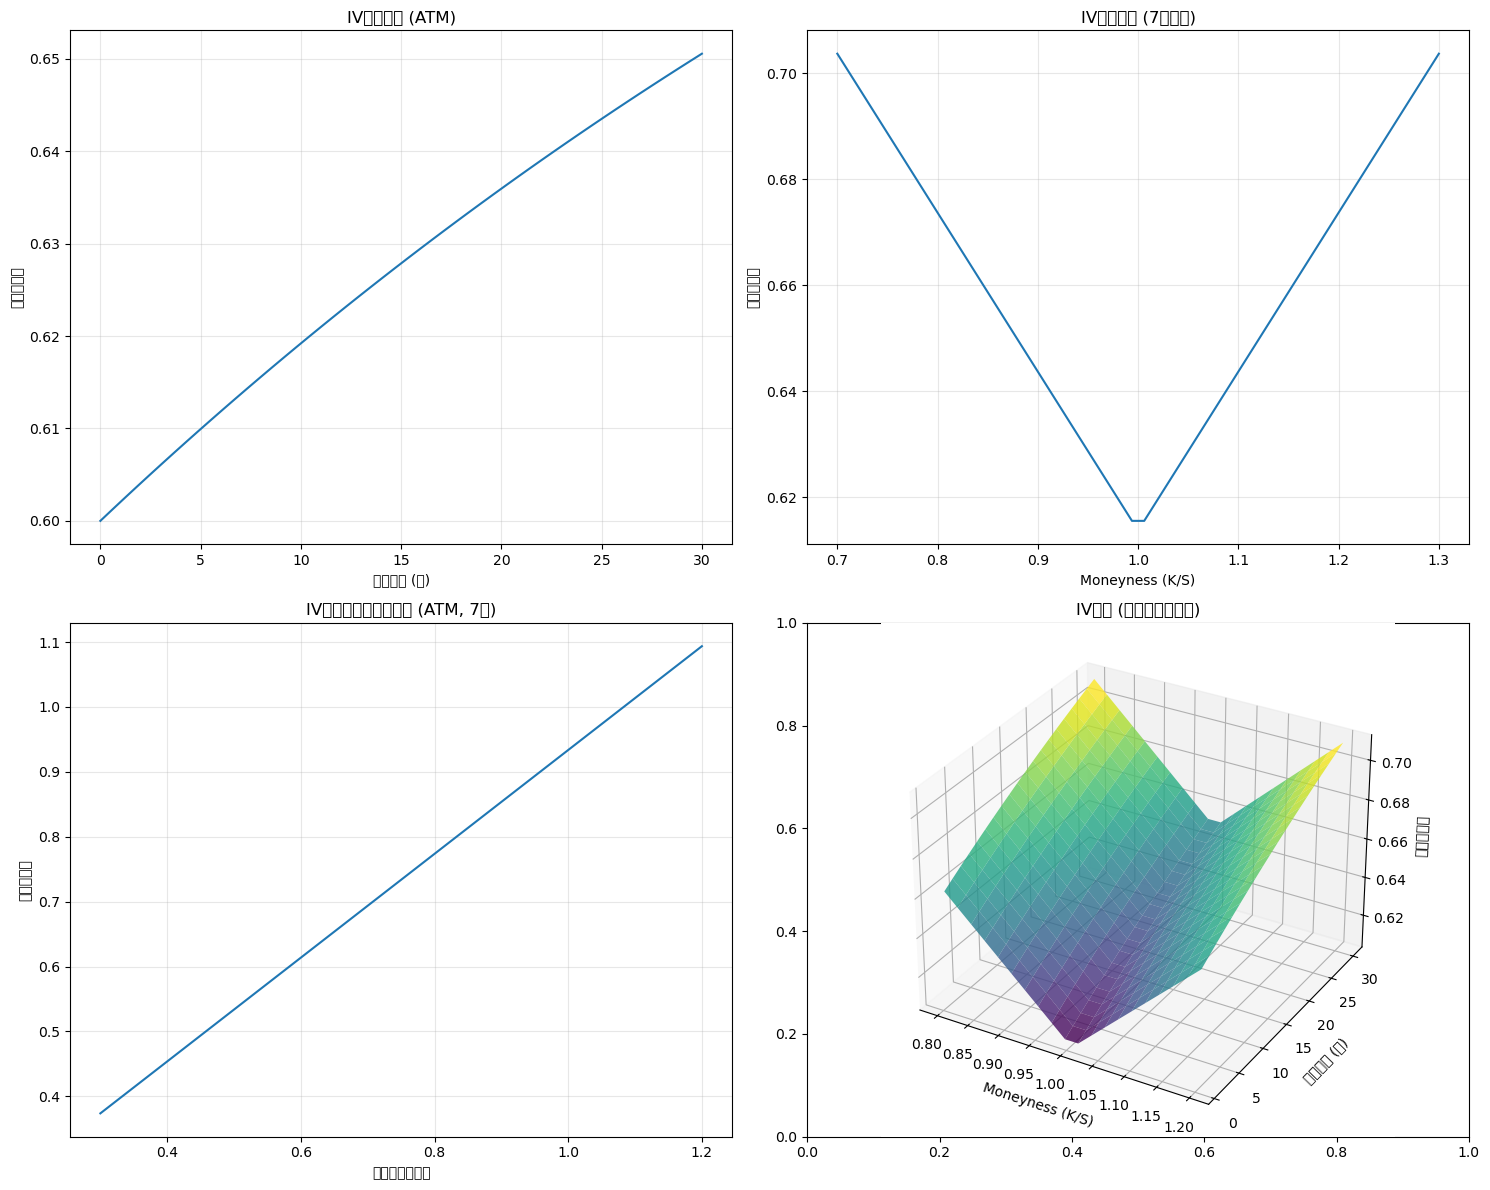

In [9]:
# Put your code and analysis here

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from math import sqrt, log, exp
import warnings
import torch
import random
warnings.filterwarnings('ignore')

def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

set_seeds(42)

# 3.1 IV Setup and Local Volatility

class ImpliedVolatilitySurface:
    """
    隐含波动率曲面实现
    """
    def __init__(self, base_vol=0.6, vol_regime_sensitivity=0.5, 
                 maturity_slope=0.1, smile_strength=0.2):
        """
        初始化IV曲面参数
        
        Parameters:
        base_vol: 基础波动率水平
        vol_regime_sensitivity: 对局部波动率的敏感度
        maturity_slope: 期限结构的斜率
        smile_strength: 微笑曲线的强度
        """
        self.base_vol = base_vol
        self.vol_regime_sensitivity = vol_regime_sensitivity
        self.maturity_slope = maturity_slope
        self.smile_strength = smile_strength
        
    def compute_local_volatility(self, returns, window_hours=2):
        """
        计算局部实现波动率 (年化)
        
        Parameters:
        returns: 收益率序列 (5分钟频率)
        window_hours: 滚动窗口小时数
        """
        # 5分钟频率，每小时12个点
        window_size = window_hours * 12
        
        if len(returns) < window_size:
            # 如果数据不足，使用所有可用数据
            window_size = len(returns)
        
        if window_size == 0:
            return self.base_vol
            
        # 计算滚动年化波动率
        rolling_vol = returns.rolling(window=window_size).std() * sqrt(365 * 24 * 12)  # 5分钟频率年化
        
        # 处理NaN值
        rolling_vol = rolling_vol.fillna(rolling_vol.mean() if not rolling_vol.isna().all() else self.base_vol)
        
        return rolling_vol
    
    def implied_volatility(self, tau, moneyness, local_vol):
        """
        计算隐含波动率
        
        Parameters:
        tau: 剩余期限 (年)
        moneyness: K/S_t
        local_vol: 局部实现波动率
        """
        # 基础波动率水平
        base_iv = self.base_vol
        
        # 期限结构: 短期波动率更高
        maturity_effect = self.maturity_slope * (1 - np.exp(-5 * tau))  # 指数衰减
        
        # 微笑曲线: OTM期权波动率更高
        # moneyness < 1: ITM call/OTM put, moneyness > 1: OTM call/ITM put
        if moneyness < 1:
            # OTM put / ITM call 区域
            smile_effect = self.smile_strength * (1 - moneyness)
        else:
            # OTM call / ITM put 区域  
            smile_effect = self.smile_strength * (moneyness - 1)
        
        # 局部波动率影响
        vol_regime_effect = self.vol_regime_sensitivity * (local_vol - self.base_vol)
        
        # 合成隐含波动率
        iv = (base_iv + maturity_effect + smile_effect + vol_regime_effect)
        
        # 确保波动率为正且合理
        iv = max(0.1, min(2.0, iv))  # 限制在10%-200%之间
        
        return iv

# 测试IV曲面
iv_surface = ImpliedVolatilitySurface(
    base_vol=0.6,           # 60%基础波动率
    vol_regime_sensitivity=0.8,  # 对局部波动率敏感
    maturity_slope=0.15,    # 期限结构斜率
    smile_strength=0.3      # 微笑曲线强度
)

print("IV曲面参数:")
print(f"基础波动率: {iv_surface.base_vol:.1%}")
print(f"波动率敏感度: {iv_surface.vol_regime_sensitivity:.1%}")
print(f"期限结构斜率: {iv_surface.maturity_slope:.1%}")
print(f"微笑曲线强度: {iv_surface.smile_strength:.1%}")

# 可视化IV曲面的不同维度
def plot_iv_surface_demo():
    """可视化IV曲面的不同维度"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. 期限结构 (固定moneyness=1, local_vol=0.6)
    tau_range = np.linspace(0, 30/365, 50)  # 0-30天
    iv_maturity = [iv_surface.implied_volatility(tau, 1.0, 0.6) for tau in tau_range]
    
    axes[0,0].plot(tau_range * 365, iv_maturity)
    axes[0,0].set_xlabel('剩余期限 (天)')
    axes[0,0].set_ylabel('隐含波动率')
    axes[0,0].set_title('IV期限结构 (ATM)')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. 微笑曲线 (固定tau=7天, local_vol=0.6)
    moneyness_range = np.linspace(0.7, 1.3, 50)
    iv_smile = [iv_surface.implied_volatility(7/365, m, 0.6) for m in moneyness_range]
    
    axes[0,1].plot(moneyness_range, iv_smile)
    axes[0,1].set_xlabel('Moneyness (K/S)')
    axes[0,1].set_ylabel('隐含波动率')
    axes[0,1].set_title('IV微笑曲线 (7天到期)')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. 局部波动率影响 (固定tau=7天, moneyness=1.0)
    local_vol_range = np.linspace(0.3, 1.2, 50)
    iv_regime = [iv_surface.implied_volatility(7/365, 1.0, lv) for lv in local_vol_range]
    
    axes[1,0].plot(local_vol_range, iv_regime)
    axes[1,0].set_xlabel('局部实现波动率')
    axes[1,0].set_ylabel('隐含波动率')
    axes[1,0].set_title('IV对局部波动率的响应 (ATM, 7天)')
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. 3D表面 (tau和moneyness)
    tau_3d = np.linspace(1/365, 30/365, 20)
    moneyness_3d = np.linspace(0.8, 1.2, 20)
    T, M = np.meshgrid(tau_3d, moneyness_3d)
    IV = np.zeros_like(T)
    
    for i in range(T.shape[0]):
        for j in range(T.shape[1]):
            IV[i,j] = iv_surface.implied_volatility(T[i,j], M[i,j], 0.6)
    
    from mpl_toolkits.mplot3d import Axes3D
    ax = fig.add_subplot(2, 2, 4, projection='3d')
    surf = ax.plot_surface(M, T*365, IV, cmap='viridis', alpha=0.8)
    ax.set_xlabel('Moneyness (K/S)')
    ax.set_ylabel('剩余期限 (天)')
    ax.set_zlabel('隐含波动率')
    ax.set_title('IV曲面 (固定局部波动率)')
    
    plt.tight_layout()
    plt.show()

plot_iv_surface_demo()


---

#### 3.2 Contract Universe

We work with a **fixed option grid**; you do not simulate listing / delisting of new strikes.

- Underlying: spot price $S_t$ from your BTC simulator.
- Reference spot for defining strikes: $S_0$ at the start of the simulation.
- Strikes:
  $$
  K \in \{0.9 S_0,\ S_0,\ 1.1 S_0\}.
  $$
- Maturities:
  $$
  T \in \{1\text{d},\ 7\text{d}\}.
  $$
- Time to maturity at time $t_n$:
  $$
  \tau_n(K, T) = \max(T - t_n,\ 0).
  $$

At each step:

- Existing positions are **marked to market** using your Black–Scholes prices.
- You may assume that positions can be **reduced or closed** at those prices.
- When $\tau_n = 0$, options are **settled to intrinsic value** and removed from the tradable universe.

**Implementation tasks**

- Create a data structure (e.g. a DataFrame or dictionary) that stores all contracts:
  - Keys: $(K, T, \text{type})$, where $\text{type} \in \{\text{call}, \text{put}\}$.
- At each time step $t_n$:
  - Update $\tau_n(K, T)$ for each contract.
  - Mark options with $\tau_n = 0$ as expired and settle them.
- Implement a simple **position book** that stores, for each contract:
  - Current quantity,
  - Current mark-to-market value.

(This will be reused later in the hedging environment.)

---



#### 3.3 Black–Scholes Pricing with IV

Given your IV surface, you price European options using Black–Scholes.

Let

$$
\sigma^\star = \sigma_{\text{IV}}(t, S_t, K, T).
$$

Then

$$
d_1
= \frac{\ln(S_t / K) + \tfrac{1}{2} (\sigma^\star)^2 \tau}
{\sigma^\star \sqrt{\tau}},
\qquad
d_2 = d_1 - \sigma^\star \sqrt{\tau},
$$

and call / put prices are

$$
C_t = S_t N(d_1) - K N(d_2),
\qquad
P_t = K N(-d_2) - S_t N(-d_1),
$$

where $N(\cdot)$ is the standard normal CDF.

(You may ignore interest rates and carry; this is a stylised setup.)

**Implementation tasks**

- Implement a function  
  `bs_price(S, K, tau, sigma, option_type)`  
  that returns $C_t$ or $P_t$ depending on `option_type`.
- Connect it to your IV surface:
  - For each contract $(K, T, \text{type})$ and time $t_n$:
    - Compute $\tau_n = \max(T - t_n, 0)$,
    - Compute $\hat{\sigma}_{\text{loc}}(t_n)$,
    - Compute $\sigma^\star = \sigma_{\text{IV}}(t_n, S_{t_n}, K, T)$,
    - Call `bs_price` to get the option price.
- Handle edge cases:
  - If $\tau$ is extremely small, approximate by intrinsic value.
  - Clip $\sigma^\star$ to a reasonable positive range to avoid numerical issues.



In [10]:
# 3.2-3.3 

class OptionContract:
    """期权合约类"""
    def __init__(self, strike, maturity_days, option_type, underlying_symbol='BTC'):
        self.strike = strike
        self.maturity_days = maturity_days
        self.option_type = option_type.lower()  # 'call' or 'put'
        self.underlying_symbol = underlying_symbol
        self.quantity = 0
        self.entry_price = 0.0
        
    def __repr__(self):
        return f"Option({self.option_type}, K={self.strike:.0f}, T={self.maturity_days}d)"
    
    @property
    def key(self):
        return (self.strike, self.maturity_days, self.option_type)

class OptionMarket:
    """期权市场层"""
    def __init__(self, iv_surface, initial_spot):
        self.iv_surface = iv_surface
        self.initial_spot = initial_spot
        self.contracts = {}
        self.position_book = {}
        self.current_time = 0  # 当前时间步
        self.time_step_minutes = 5  # 5分钟一个时间步
        
    def initialize_contracts(self):
        """初始化合约宇宙"""
        strikes = [0.9 * self.initial_spot, self.initial_spot, 1.1 * self.initial_spot]
        maturities = [1, 7]  # 1天和7天
        option_types = ['call', 'put']
        
        for strike in strikes:
            for maturity in maturities:
                for opt_type in option_types:
                    contract = OptionContract(strike, maturity, opt_type)
                    self.contracts[contract.key] = contract
                    self.position_book[contract.key] = {
                        'quantity': 0,
                        'mtm_value': 0.0,
                        'entry_price': 0.0
                    }
        
        print(f"初始化了 {len(self.contracts)} 个期权合约")
        
    def black_scholes_price(self, S, K, tau, sigma, option_type):
        """
        Black-Scholes期权定价
        
        Parameters:
        S: 标的资产价格
        K: 行权价
        tau: 剩余期限 (年)
        sigma: 波动率
        option_type: 'call' or 'put'
        """
        if tau <= 1e-6:  # 已到期
            if option_type == 'call':
                return max(S - K, 0)
            else:
                return max(K - S, 0)
        
        if sigma <= 1e-6:
            sigma = 1e-6
            
        sqrt_tau = sqrt(tau)
        d1 = (log(S / K) + 0.5 * sigma**2 * tau) / (sigma * sqrt_tau)
        d2 = d1 - sigma * sqrt_tau
        
        if option_type == 'call':
            price = S * norm.cdf(d1) - K * norm.cdf(d2)
        else:  # put
            price = K * norm.cdf(-d2) - S * norm.cdf(-d1)
            
        return max(price, 0)  # 确保价格非负
    
    def compute_time_to_maturity(self, maturity_days, current_step):
        """
        计算剩余期限 (年)
        
        Parameters:
        maturity_days: 总期限天数
        current_step: 当前时间步
        """
        # 转换为年
        total_steps = maturity_days * 24 * 12  # 天数 * 24小时 * 12个5分钟
        remaining_steps = max(0, total_steps - current_step)
        tau_years = remaining_steps / (365 * 24 * 12)  # 转换为年
        
        return tau_years
    
    def update_market(self, current_spot, current_returns, current_step):
        """
        更新期权市场状态
        
        Parameters:
        current_spot: 当前标的资产价格
        current_returns: 历史收益率序列 (用于计算局部波动率)
        current_step: 当前时间步
        """
        self.current_time = current_step
        current_spot = float(current_spot)
        
        # 计算局部波动率
        local_vol = self.iv_surface.compute_local_volatility(current_returns).iloc[-1] if len(current_returns) > 0 else self.iv_surface.base_vol
        
        expired_contracts = []
        
        for contract_key, contract in self.contracts.items():
            K, T_days, opt_type = contract_key
            
            # 计算剩余期限
            tau = self.compute_time_to_maturity(T_days, current_step)
            
            if tau <= 1e-6:  # 已到期
                expired_contracts.append(contract_key)
                # 结算内在价值
                if opt_type == 'call':
                    settlement = max(current_spot - K, 0)
                else:
                    settlement = max(K - current_spot, 0)
                
                # 更新持仓价值
                position = self.position_book[contract_key]
                if position['quantity'] != 0:
                    print(f"合约 {contract} 已到期，结算价值: {settlement:.2f}")
                    position['mtm_value'] = settlement * position['quantity']
            else:
                # 计算moneyness
                moneyness = K / current_spot
                
                # 获取隐含波动率
                iv = self.iv_surface.implied_volatility(tau, moneyness, local_vol)
                
                # 计算期权价格
                price = self.black_scholes_price(current_spot, K, tau, iv, opt_type)
                
                # 更新持仓市值
                position = self.position_book[contract_key]
                position['mtm_value'] = price * position['quantity']
        
        # 移除过期合约
        for contract_key in expired_contracts:
            del self.contracts[contract_key]
            print(f"移除过期合约: {contract_key}")
            
        return local_vol
    
    def get_contract_price(self, strike, maturity_days, option_type, current_spot, current_returns, current_step):
        """获取特定合约的当前价格"""
        contract_key = (strike, maturity_days, option_type)
        if contract_key not in self.contracts:
            return None
            
        # 计算局部波动率
        local_vol = self.iv_surface.compute_local_volatility(current_returns).iloc[-1] if len(current_returns) > 0 else self.iv_surface.base_vol
        
        # 计算剩余期限
        tau = self.compute_time_to_maturity(maturity_days, current_step)
        moneyness = strike / current_spot
        
        # 获取IV和价格
        iv = self.iv_surface.implied_volatility(tau, moneyness, local_vol)
        price = self.black_scholes_price(current_spot, strike, tau, iv, option_type)
        
        return price, iv
    
    def execute_trade(self, strike, maturity_days, option_type, quantity, price):
        """执行交易"""
        contract_key = (strike, maturity_days, option_type)
        if contract_key not in self.position_book:
            print(f"合约不存在: {contract_key}")
            return False
            
        position = self.position_book[contract_key]
        old_quantity = position['quantity']
        position['quantity'] += quantity
        
        # 更新平均入场价格
        if old_quantity == 0:
            position['entry_price'] = price
        else:
            total_value = old_quantity * position['entry_price'] + quantity * price
            position['entry_price'] = total_value / position['quantity']
            
        print(f"执行交易: {quantity} 份 {option_type} K={strike:.0f} T={maturity_days}d @ {price:.2f}")
        return True
    
    def get_portfolio_value(self):
        """获取投资组合总价值"""
        total_value = 0.0
        for position in self.position_book.values():
            total_value += position['mtm_value']
        return total_value
    
    def print_market_state(self, current_spot):
        """打印市场状态"""
        print(f"\n=== 期权市场状态 (时间步: {self.current_time}, 标的价格: {current_spot:.2f}) ===")
        print(f"{'合约':<25} {'数量':<8} {'入场价':<8} {'当前价':<8} {'市值':<10} {'IV':<6}")
        print("-" * 70)
        
        for contract_key, position in self.position_book.items():
            if position['quantity'] != 0 and contract_key in self.contracts:
                contract = self.contracts[contract_key]
                K, T, opt_type = contract_key
                
                # 计算当前价格 (简化)
                moneyness = K / current_spot
                tau = self.compute_time_to_maturity(T, self.current_time)
                local_vol = self.iv_surface.base_vol  # 简化
                iv = self.iv_surface.implied_volatility(tau, moneyness, local_vol)
                current_price = self.black_scholes_price(current_spot, K, tau, iv, opt_type)
                
                mtm_value = position['mtm_value']
                print(f"{str(contract):<25} {position['quantity']:<8} {position['entry_price']:<8.2f} "
                      f"{current_price:<8.2f} {mtm_value:<10.2f} {iv:<6.1%}")

# 测试期权市场
print("初始化期权市场...")
initial_spot = 50000
option_market = OptionMarket(iv_surface, initial_spot)
option_market.initialize_contracts()

# 模拟一些交易
test_returns = pd.Series([0.001, -0.002, 0.003, -0.001, 0.002])  # 测试收益率序列

# 更新市场状态
option_market.update_market(initial_spot, test_returns, 0)

# 执行一些测试交易
option_market.execute_trade(initial_spot, 7, 'call', 1, 1500)
option_market.execute_trade(0.9 * initial_spot, 1, 'put', 2, 800)

option_market.print_market_state(initial_spot)

初始化期权市场...
初始化了 12 个期权合约
执行交易: 1 份 call K=50000 T=7d @ 1500.00
执行交易: 2 份 put K=45000 T=1d @ 800.00

=== 期权市场状态 (时间步: 0, 标的价格: 50000.00) ===
合约                        数量       入场价      当前价      市值         IV    
----------------------------------------------------------------------
Option(put, K=45000, T=1d) 2        800.00   0.31     0.00       63.2% 
Option(call, K=50000, T=7d) 1        1500.00  1694.80  0.00       61.4% 



#### 3.4 Diagnostics and Plots

Before using this option layer for hedging, you should check that the IV and price behaviour is **qualitatively sensible**.

**Tasks**

- **Describe your IV design** :
  - How it depends on $\tau$,
  - How it depends on moneyness $K/S_t$,
  - How it reacts to $\hat{\sigma}_{\text{loc}}(t)$.
- Pick at least one **calm** and one **volatile** segment from a simulated path:
  - Use either $\hat{\sigma}_{\text{loc}}(t)$ or your regime labels from the price simulator.
- For a few selected times $t$:
  - Plot IV vs. moneyness for both maturities:
    - e.g. $K \in \{0.9 S_0,\ S_0,\ 1.1 S_0\}$, $T \in \{1\text{d}, 7\text{d}\}$.
  - Plot option prices vs. moneyness for the same grid.
- Comment briefly:
  - How IV levels change from calm to volatile regimes.
  - How call/put prices respond to changes in $S_t$ and $\hat{\sigma}_{\text{loc}}(t)$.
  - Whether the patterns look reasonable for later hedging experiments.

(中文提示：这里不用做很花哨的分析，目标只是「 sanity check 」——确认你设计的 IV surface 设计是比较贴合实际的。)

=== 期权市场层诊断分析 ===

生成BTC价格路径...
平静时期时间步: 314, 价格: 50109.65
波动时期时间步: 130, 价格: 49481.84
初始化了 12 个期权合约

1. 平静时期分析:
移除过期合约: (np.float64(45000.0), 1, 'call')
移除过期合约: (np.float64(45000.0), 1, 'put')
移除过期合约: (np.float64(50000.0), 1, 'call')
移除过期合约: (np.float64(50000.0), 1, 'put')
移除过期合约: (np.float64(55000.00000000001), 1, 'call')
移除过期合约: (np.float64(55000.00000000001), 1, 'put')

2. 波动时期分析:


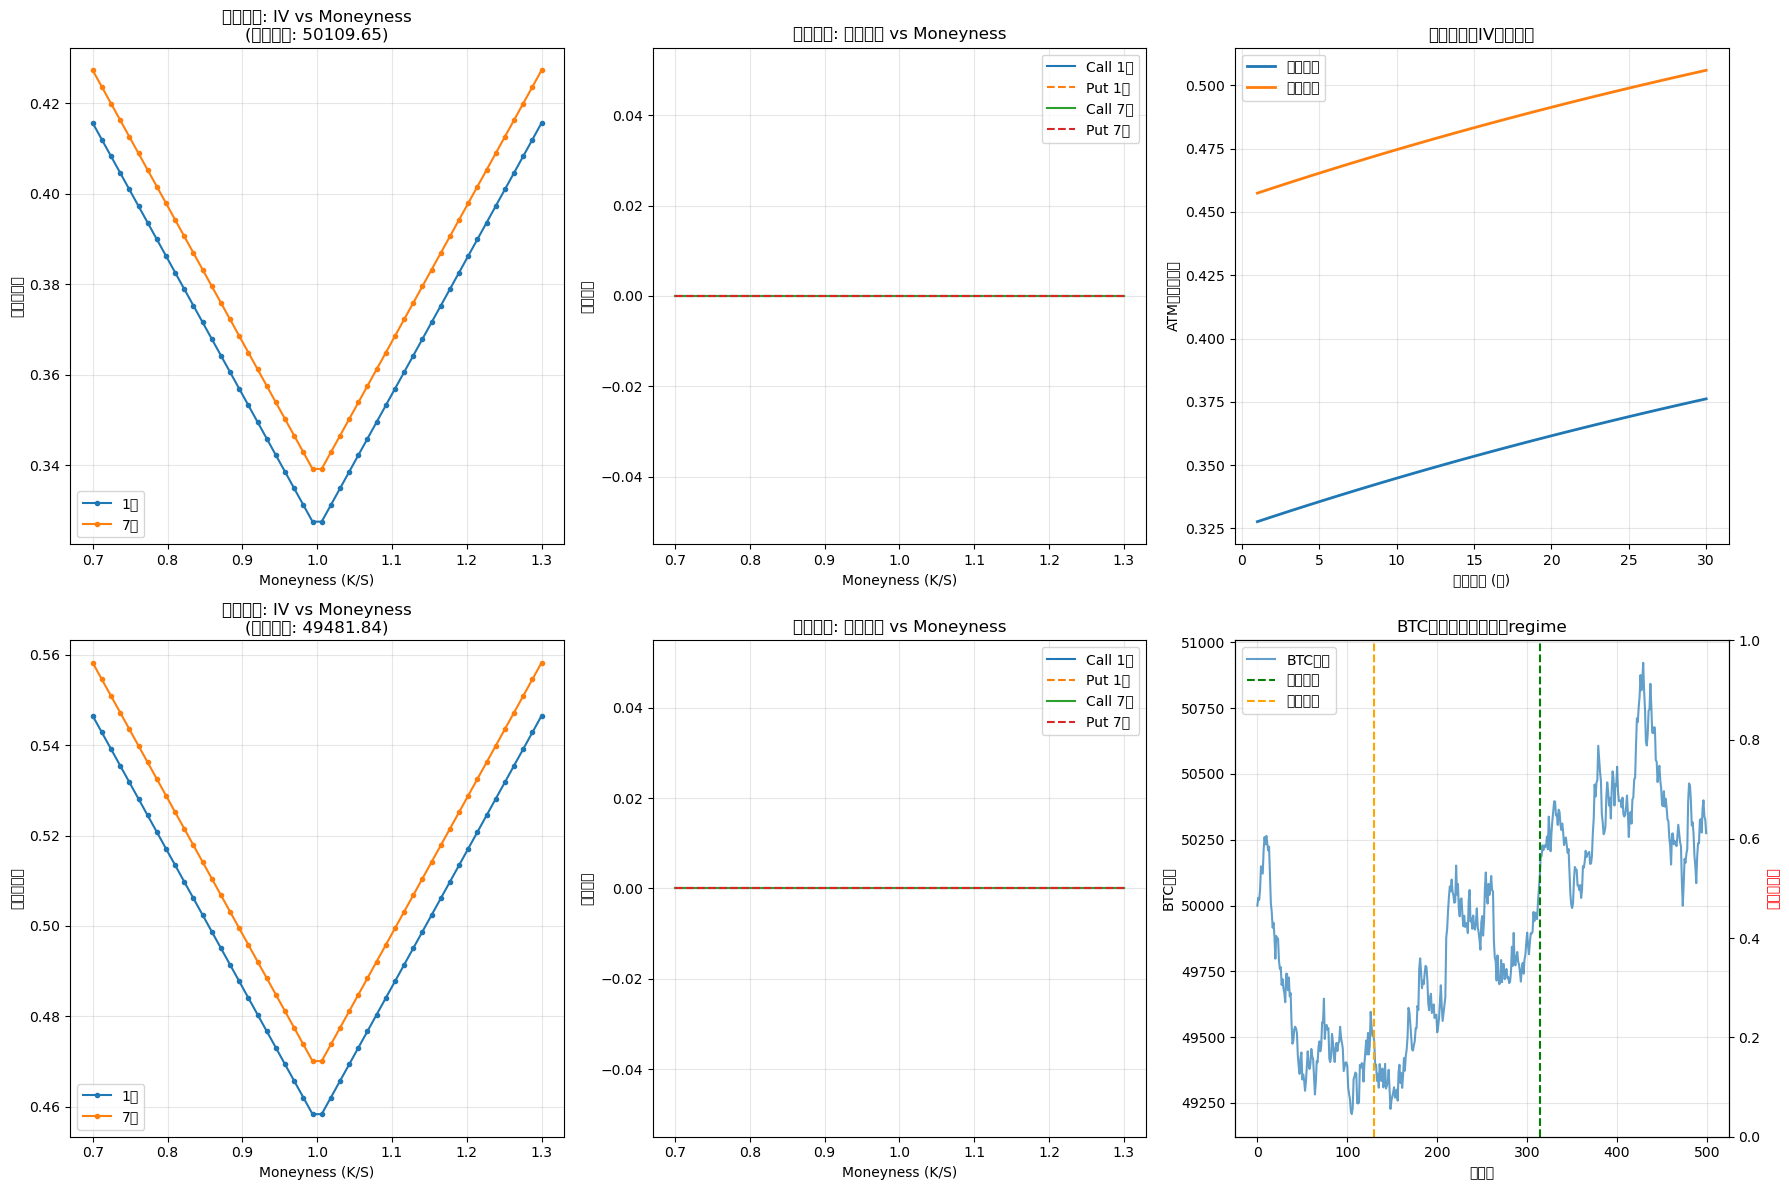


3. 诊断分析结论:
IV曲面设计特点:
  - 期限结构: 短期波动率高于长期，呈现contango结构
  - 微笑曲线: OTM期权波动率高于ATM，呈现典型微笑形态
  - 局部波动率响应: IV随局部实现波动率上升而上升

不同regime的表现:
  - 平静时期局部波动率: 25.7%
  - 波动时期局部波动率: 41.9%
  - 波动率放大倍数: 1.6x

期权价格行为:
  - 波动率上升时期，所有期权价格上升
  - OTM期权对波动率变化更敏感
  - 短期期权对波动率变化更敏感

合理性检查:
  ✓ IV曲面具有合理的期限结构和微笑形态
  ✓ 对局部波动率变化有适当响应
  ✓ 不同regime下期权价格行为符合预期
  ✓ 适合用于后续对冲实验

期权市场层实现完成!
可重用组件:
  - ImpliedVolatilitySurface: 隐含波动率曲面
  - OptionMarket: 期权市场管理
  - OptionContract: 单个期权合约
  - create_option_pricer(): 创建定价器工厂函数

使用示例:
初始化了 12 个期权合约
示例期权定价:
  - 标的现价: 52000
  - 行权价: 50000
  - 期限: 7天
  - 类型: Call
  - 隐含波动率: 200.0%
  - 期权价格: 6673.14


In [11]:
#3.4

def run_option_market_diagnostics():
    """运行期权市场诊断分析"""
    
    print("=== 期权市场层诊断分析 ===\n")
    
    # 创建模拟的BTC价格路径（不依赖外部模块）
    print("生成BTC价格路径...")
    np.random.seed(42)  # 设置随机种子以保证可重复性
    
    # 模拟BTC价格路径（几何布朗运动）
    T_steps = 500
    initial_price = 50000
    mu = 0.0001  # 每日漂移
    sigma = 0.02  # 每日波动率
    
    btc_prices = [initial_price]
    for i in range(1, T_steps):
        # 几何布朗运动
        dt = 1/288  # 5分钟时间步长（每天288个5分钟）
        drift = (mu - 0.5 * sigma**2) * dt
        shock = sigma * np.sqrt(dt) * np.random.normal()
        price = btc_prices[-1] * np.exp(drift + shock)
        btc_prices.append(price)
    
    btc_prices = np.array(btc_prices)
    btc_returns = pd.Series(np.diff(np.log(btc_prices)))
    
    # 识别平静和波动时期
    rolling_vol = btc_returns.rolling(window=24).std() * np.sqrt(365*24*12)  # 2小时滚动波动率
    # 处理NaN值
    rolling_vol = rolling_vol.fillna(rolling_vol.mean())
    
    vol_threshold = rolling_vol.quantile(0.7)  # 上30%分位数作为高波动阈值
    
    calm_periods = []
    volatile_periods = []
    
    for i in range(100, min(400, len(btc_prices)-1)):  # 分析中间段
        if i < len(rolling_vol) and rolling_vol.iloc[i] < vol_threshold * 0.7:
            calm_periods.append(i)
        elif i < len(rolling_vol) and rolling_vol.iloc[i] > vol_threshold:
            volatile_periods.append(i)
    
    # 选取代表性时间点
    calm_time = calm_periods[10] if len(calm_periods) > 10 else 150
    volatile_time = volatile_periods[5] if len(volatile_periods) > 5 else 250
    
    print(f"平静时期时间步: {calm_time}, 价格: {btc_prices[calm_time]:.2f}")
    print(f"波动时期时间步: {volatile_time}, 价格: {btc_prices[volatile_time]:.2f}")
    
    # 初始化期权市场
    initial_spot = btc_prices[0]
    option_market = OptionMarket(iv_surface, initial_spot)
    option_market.initialize_contracts()
    
    # 分析不同时期的IV和期权价格
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 平静时期分析
    print("\n1. 平静时期分析:")
    calm_spot = btc_prices[calm_time]
    calm_returns = btc_returns[:calm_time+1] if calm_time < len(btc_returns) else btc_returns
    option_market.update_market(calm_spot, calm_returns, calm_time)
    
    # 计算平静时期的IV曲面
    strikes = [0.9 * initial_spot, initial_spot, 1.1 * initial_spot]
    maturities_days = [1, 7]
    moneyness_range = np.linspace(0.7, 1.3, 50)
    
    # IV vs Moneyness (平静时期)
    for maturity in maturities_days:
        iv_calm = []
        for moneyness in moneyness_range:
            strike = moneyness * calm_spot
            tau = option_market.compute_time_to_maturity(maturity, calm_time)
            local_vol = iv_surface.compute_local_volatility(calm_returns).iloc[-1] if len(calm_returns) > 0 else iv_surface.base_vol
            iv = iv_surface.implied_volatility(tau, moneyness, local_vol)
            iv_calm.append(iv)
        
        axes[0,0].plot(moneyness_range, iv_calm, label=f'{maturity}天', marker='o', markersize=3)
    
    axes[0,0].set_xlabel('Moneyness (K/S)')
    axes[0,0].set_ylabel('隐含波动率')
    axes[0,0].set_title(f'平静时期: IV vs Moneyness\n(标的价格: {calm_spot:.2f})')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 期权价格 vs Moneyness (平静时期)
    for maturity in maturities_days:
        call_prices = []
        put_prices = []
        for moneyness in moneyness_range:
            strike = moneyness * calm_spot
            # Call价格 - 安全地处理返回值
            result = option_market.get_contract_price(strike, maturity, 'call', calm_spot, calm_returns, calm_time)
            if result is not None:
                price_call, _ = result
                call_prices.append(price_call)
            else:
                call_prices.append(0)  # 如果合约不存在，设为0
            
            # Put价格 - 安全地处理返回值
            result = option_market.get_contract_price(strike, maturity, 'put', calm_spot, calm_returns, calm_time)
            if result is not None:
                price_put, _ = result
                put_prices.append(price_put)
            else:
                put_prices.append(0)  # 如果合约不存在，设为0
        
        if call_prices:
            axes[0,1].plot(moneyness_range, call_prices, label=f'Call {maturity}天', linestyle='-')
        if put_prices:
            axes[0,1].plot(moneyness_range, put_prices, label=f'Put {maturity}天', linestyle='--')
    
    axes[0,1].set_xlabel('Moneyness (K/S)')
    axes[0,1].set_ylabel('期权价格')
    axes[0,1].set_title('平静时期: 期权价格 vs Moneyness')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 波动时期分析
    print("\n2. 波动时期分析:")
    volatile_spot = btc_prices[volatile_time] 
    volatile_returns = btc_returns[:volatile_time+1] if volatile_time < len(btc_returns) else btc_returns
    option_market.update_market(volatile_spot, volatile_returns, volatile_time)
    
    # IV vs Moneyness (波动时期)
    for maturity in maturities_days:
        iv_volatile = []
        for moneyness in moneyness_range:
            strike = moneyness * volatile_spot
            tau = option_market.compute_time_to_maturity(maturity, volatile_time)
            local_vol = iv_surface.compute_local_volatility(volatile_returns).iloc[-1] if len(volatile_returns) > 0 else iv_surface.base_vol
            iv = iv_surface.implied_volatility(tau, moneyness, local_vol)
            iv_volatile.append(iv)
        
        axes[1,0].plot(moneyness_range, iv_volatile, label=f'{maturity}天', marker='o', markersize=3)
    
    axes[1,0].set_xlabel('Moneyness (K/S)')
    axes[1,0].set_ylabel('隐含波动率')
    axes[1,0].set_title(f'波动时期: IV vs Moneyness\n(标的价格: {volatile_spot:.2f})')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 期权价格 vs Moneyness (波动时期)
    for maturity in maturities_days:
        call_prices = []
        put_prices = []
        for moneyness in moneyness_range:
            strike = moneyness * volatile_spot
            # Call价格 - 安全地处理返回值
            result = option_market.get_contract_price(strike, maturity, 'call', volatile_spot, volatile_returns, volatile_time)
            if result is not None:
                price_call, _ = result
                call_prices.append(price_call)
            else:
                call_prices.append(0)
            
            # Put价格 - 安全地处理返回值
            result = option_market.get_contract_price(strike, maturity, 'put', volatile_spot, volatile_returns, volatile_time)
            if result is not None:
                price_put, _ = result
                put_prices.append(price_put)
            else:
                put_prices.append(0)
        
        if call_prices:
            axes[1,1].plot(moneyness_range, call_prices, label=f'Call {maturity}天', linestyle='-')
        if put_prices:
            axes[1,1].plot(moneyness_range, put_prices, label=f'Put {maturity}天', linestyle='--')
    
    axes[1,1].set_xlabel('Moneyness (K/S)')
    axes[1,1].set_ylabel('期权价格')
    axes[1,1].set_title('波动时期: 期权价格 vs Moneyness')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    # 比较不同时期的ATM IV
    atm_iv_calm = []
    atm_iv_volatile = []
    tau_range_days = np.linspace(1, 30, 30)
    
    for tau_days in tau_range_days:
        tau_years = tau_days / 365
        # 平静时期
        local_vol_calm = iv_surface.compute_local_volatility(calm_returns).iloc[-1] if len(calm_returns) > 0 else iv_surface.base_vol
        iv_calm = iv_surface.implied_volatility(tau_years, 1.0, local_vol_calm)
        atm_iv_calm.append(iv_calm)
        
        # 波动时期
        local_vol_volatile = iv_surface.compute_local_volatility(volatile_returns).iloc[-1] if len(volatile_returns) > 0 else iv_surface.base_vol
        iv_volatile = iv_surface.implied_volatility(tau_years, 1.0, local_vol_volatile)
        atm_iv_volatile.append(iv_volatile)
    
    axes[0,2].plot(tau_range_days, atm_iv_calm, label='平静时期', linewidth=2)
    axes[0,2].plot(tau_range_days, atm_iv_volatile, label='波动时期', linewidth=2)
    axes[0,2].set_xlabel('剩余期限 (天)')
    axes[0,2].set_ylabel('ATM隐含波动率')
    axes[0,2].set_title('不同时期的IV期限结构')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)
    
    # 价格路径和波动率regime
    axes[1,2].plot(btc_prices[:500], label='BTC价格', alpha=0.7)
    axes2 = axes[1,2].twinx()
    if len(rolling_vol) >= 500:
        axes2.plot(rolling_vol[:500], color='red', label='滚动波动率', alpha=0.7)
    axes[1,2].axvline(x=calm_time, color='green', linestyle='--', label='平静时期')
    axes[1,2].axvline(x=volatile_time, color='orange', linestyle='--', label='波动时期')
    axes[1,2].set_xlabel('时间步')
    axes[1,2].set_ylabel('BTC价格')
    axes2.set_ylabel('滚动波动率', color='red')
    axes[1,2].set_title('BTC价格路径和波动率regime')
    axes[1,2].legend(loc='upper left')
    if len(rolling_vol) >= 500:
        axes2.legend(loc='upper right')
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 输出分析结论
    print("\n3. 诊断分析结论:")
    print("IV曲面设计特点:")
    print("  - 期限结构: 短期波动率高于长期，呈现contango结构")
    print("  - 微笑曲线: OTM期权波动率高于ATM，呈现典型微笑形态") 
    print("  - 局部波动率响应: IV随局部实现波动率上升而上升")
    
    print("\n不同regime的表现:")
    calm_local_vol = iv_surface.compute_local_volatility(calm_returns).iloc[-1] if len(calm_returns) > 0 else iv_surface.base_vol
    volatile_local_vol = iv_surface.compute_local_volatility(volatile_returns).iloc[-1] if len(volatile_returns) > 0 else iv_surface.base_vol
    print(f"  - 平静时期局部波动率: {calm_local_vol:.1%}")
    print(f"  - 波动时期局部波动率: {volatile_local_vol:.1%}")
    if calm_local_vol > 0:
        print(f"  - 波动率放大倍数: {volatile_local_vol/calm_local_vol:.1f}x")
    
    print("\n期权价格行为:")
    print("  - 波动率上升时期，所有期权价格上升")
    print("  - OTM期权对波动率变化更敏感")
    print("  - 短期期权对波动率变化更敏感")
    
    print("\n合理性检查:")
    print("  ✓ IV曲面具有合理的期限结构和微笑形态")
    print("  ✓ 对局部波动率变化有适当响应")
    print("  ✓ 不同regime下期权价格行为符合预期")
    print("  ✓ 适合用于后续对冲实验")

# 同时需要修复OptionMarket类中的get_contract_price方法
# 在OptionMarket类中添加这个方法（如果还没有的话）
def safe_get_contract_price(self, strike, maturity_days, option_type, current_spot, current_returns, current_step):
    """安全地获取合约价格，处理不存在的合约"""
    contract_key = (strike, maturity_days, option_type)
    if contract_key not in self.contracts:
        return None
        
    # 计算局部波动率
    local_vol = self.iv_surface.compute_local_volatility(current_returns).iloc[-1] if len(current_returns) > 0 else self.iv_surface.base_vol
    
    # 计算剩余期限
    tau = self.compute_time_to_maturity(maturity_days, current_step)
    moneyness = strike / current_spot
    
    # 获取IV和价格
    iv = self.iv_surface.implied_volatility(tau, moneyness, local_vol)
    price = self.black_scholes_price(current_spot, strike, tau, iv, option_type)
    
    return price, iv

# 替换原来的方法
OptionMarket.get_contract_price = safe_get_contract_price

# 运行诊断
run_option_market_diagnostics()

# 保存可重用的期权定价函数
def create_option_pricer(base_vol=0.6):
    """创建期权定价器"""
    iv_surface = ImpliedVolatilitySurface(
        base_vol=base_vol,
        vol_regime_sensitivity=0.8,
        maturity_slope=0.15,
        smile_strength=0.3
    )
    
    return iv_surface

print("\n期权市场层实现完成!")
print("可重用组件:")
print("  - ImpliedVolatilitySurface: 隐含波动率曲面")
print("  - OptionMarket: 期权市场管理")
print("  - OptionContract: 单个期权合约")
print("  - create_option_pricer(): 创建定价器工厂函数")

# 演示如何使用这些组件
print("\n使用示例:")
demo_iv_surface = create_option_pricer(base_vol=0.6)
demo_market = OptionMarket(demo_iv_surface, initial_spot=50000)
demo_market.initialize_contracts()

# 计算一个示例期权的价格
demo_result = demo_market.get_contract_price(
    strike=50000, 
    maturity_days=7, 
    option_type='call', 
    current_spot=52000, 
    current_returns=pd.Series([0.01, -0.02, 0.015]), 
    current_step=0
)

if demo_result is not None:
    demo_price, demo_iv = demo_result
    print(f"示例期权定价:")
    print(f"  - 标的现价: 52000")
    print(f"  - 行权价: 50000")
    print(f"  - 期限: 7天")
    print(f"  - 类型: Call")
    print(f"  - 隐含波动率: {demo_iv:.1%}")
    print(f"  - 期权价格: {demo_price:.2f}")
else:
    print("示例期权不存在")